In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Activation, Concatenate, Dropout, Input, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.io import imsave
import os
import pickle
%matplotlib inline

In [ ]:
#import the data
path = '/content/drive/My Drive/datasets/Images256_256/'
X = []
for f in os.listdir(path):
  x = img_to_array(load_img(path+f))
  X.append(x)

In [ ]:
X = np.array(X, dtype='float32')
np.random.shuffle(X)
X = 1.0/255.0 * X
Xlab = rgb2lab(X)
XtestLab = Xlab[:65]
XtrainLab = Xlab[65:]
Xtrain = [(XtrainLab[:,:,:,0]/50) - 1, ((XtrainLab[:,:,:,1:]+128.0)/255*2)-1]
Xtrain[0] = Xtrain[0].reshape((-1,256,256,1))
Xtest = [(XtestLab[:,:,:,0]/50) -1, ((XtestLab[:,:,:,1:]+128.0)/255*2)-1]

In [ ]:
#saving the final dataset with pickle
with open('/content/drive/My Drive/datasets/Images256_256PickleOutput/Xtrain.p', 'wb') as f:
  pickle.dump(Xtrain, f)

In [ ]:
with open('/content/drive/My Drive/datasets/Images256_256PickleOutput/Xtest.p', 'wb') as f:
  pickle.dump(Xtest, f)

In [ ]:
def make_generator(input_shape=(256,256,1)):
  init = tf.keras.initializers.RandomNormal(stddev=0.02)
  f = 64
  def genE(lay_inp, filters_n, bn=True):
    g = Conv2D(filters_n, (4,4), (2,2), padding='same', kernel_initializer=init)(lay_inp)
    if bn:
      g = BatchNormalization(momentum=0.8)(g)
    g = LeakyReLU(0.2)(g)
    return g
  
  def genD(lay_inp, skip_inp, filters_n, dropout=0.0):
    d = Conv2DTranspose(filters_n, (4,4), (2,2), padding='same', kernel_initializer=init)(lay_inp)
    d = BatchNormalization(momentum=0.8)(d)
    if dropout>0.0:
      d = Dropout(dropout)(d)
    d = Concatenate()([d, skip_inp])
    d = Activation('relu')(d)
    return d

  in_img = Input(shape = input_shape)
  e1 = genE(in_img, f, False)
  e2 = genE(e1, 2*f)
  e3 = genE(e2, 4*f)
  e4 = genE(e3, 8*f)
  e5 = genE(e4, 8*f)
  e6 = genE(e5, 8*f)
  e7 = genE(e6, 8*f)
  m = Conv2D(512,(4,4), strides=2, padding='same', kernel_initializer=init )(e7)
  m = Activation('relu')(m)
  d1 = genD(m, e7, 8*f, 0.5) 
  d2 = genD(d1, e6, 8*f, 0.5)
  d3 = genD(d2, e5, 8*f, 0.5)
  d4 = genD(d3, e4, 8*f)
  d5 = genD(d4, e3, 4*f)
  d6 = genD(d5, e2, 8*f)
  d7 = genD(d6, e1, 8*f)
  out_img = Conv2DTranspose(2, (4,4), (2,2), padding='same', kernel_initializer=init)(d7)
  out_img = Activation('tanh')(out_img)
  model = Model(in_img, out_img)
  return model

generator = make_generator()
generator.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1088        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu[0][0]                
_______________________________________________________________________________________

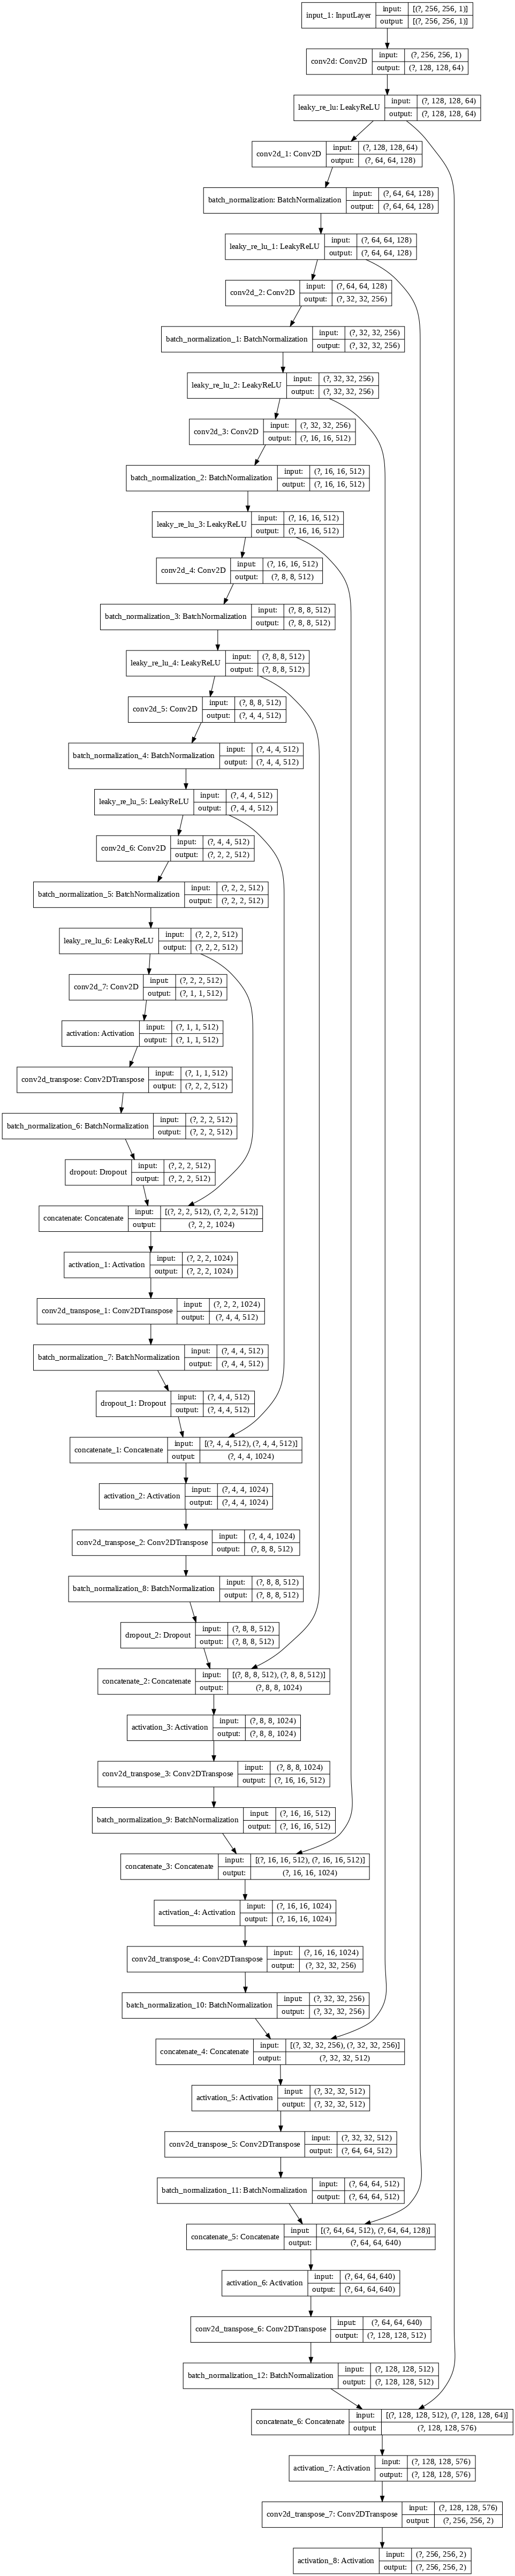

In [ ]:
tf.keras.utils.plot_model(generator, to_file='ColorGen.png', show_shapes=True, dpi=75)

In [ ]:
#define discriminator
def make_discriminator(image_shape=[(256,256,1), (256,256,2)]):
  init = tf.keras.initializers.RandomNormal(stddev=0.02)
  f = 64
  def gen(lay_inp, filters_n, strides=1, bn=True):
    d = Conv2D(filters_n, (4,4), strides = strides, padding='same', kernel_initializer=init)(lay_inp)
    if bn:
      d = BatchNormalization(momentum = 0.8)(d)
    d = LeakyReLU(0.2)(d)
    return d
  
  img1 = Input(shape = image_shape[0])
  img2 = Input(shape = image_shape[1])

  img_com = Concatenate()([img1, img2])
  d = gen(img_com, f, 2, False)
  d = gen(d, 2*f, 2)
  d = gen(d, 4*f, 2)
  d = gen(d, 8*f, 2)
  d = gen(d, 8*f)
  d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  outPut = Activation('sigmoid')(d)

  model = Model([img1, img2], outPut)
  opt = Adam(0.0002, 0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model
  
discriminator = make_discriminator()
discriminator.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 3)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 64) 3136        concatenate_7[0][0]   

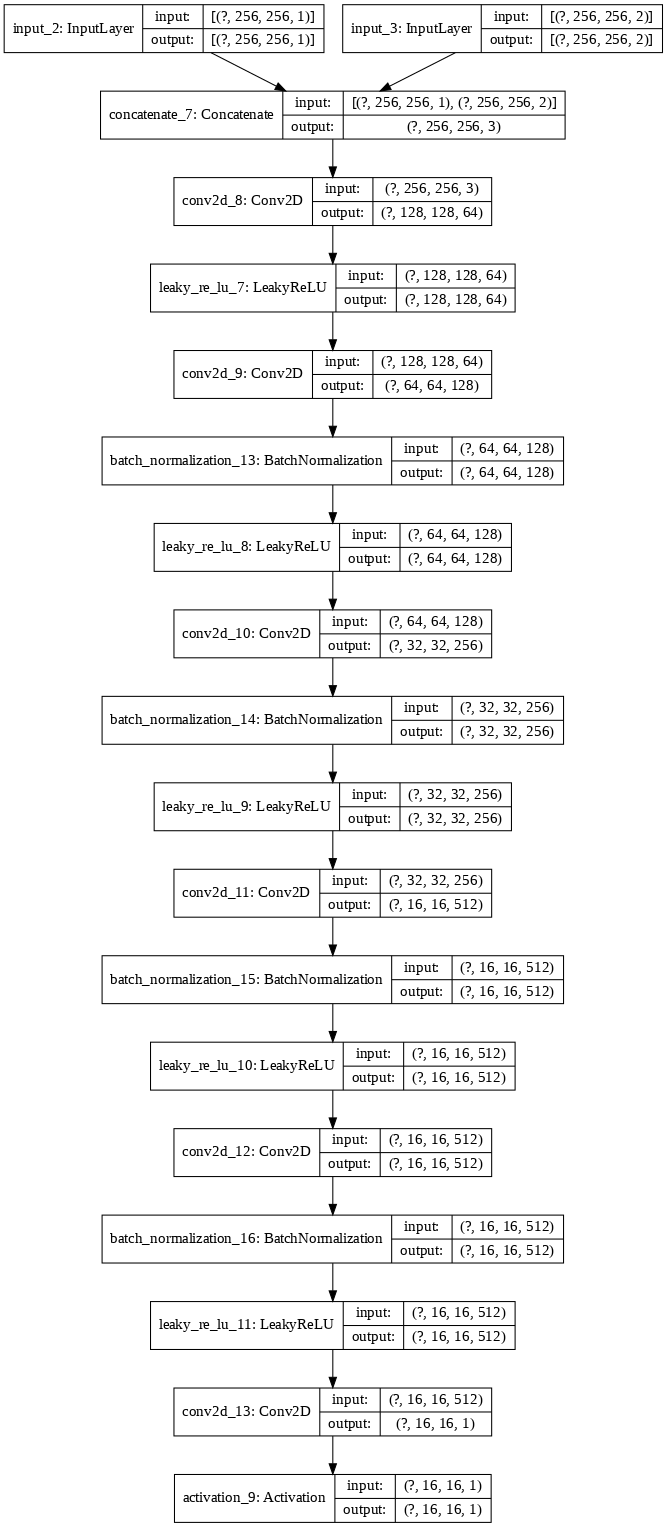

In [ ]:
tf.keras.utils.plot_model(discriminator, to_file='ColorDis.png', show_shapes=True, dpi=75)

In [ ]:
#making the complete Gan model for training generator
def make_gan(gen, dis, image_shape=(256,256,1)):
  dis.trainable = False
  inp_img = Input(shape = image_shape)
  generatorOutput = gen(inp_img)
  discriminatorOutput = dis([inp_img, generatorOutput])
  model = Model(inp_img, [discriminatorOutput, generatorOutput])
  opt = Adam(0.0002, 0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])
  return model

gan = make_gan(generator, discriminator)
gan.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 256, 256, 2)  62570178    input_4[0][0]                    
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 16, 16, 1)    6965185     input_4[0][0]                    
                                                                 functional_1[0][0]               
Total params: 69,535,363
Trainable params: 62,558,658
Non-trainable params: 6,976,705
__________________________________________________________________________________________________


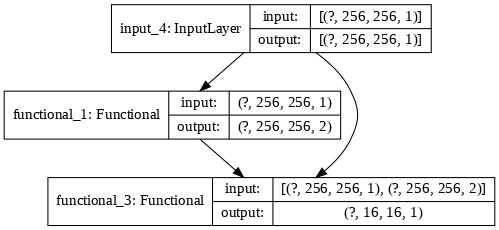

In [ ]:
tf.keras.utils.plot_model(gan, to_file='ColorGAN.png', show_shapes=True, dpi=75)

In [ ]:
#initializations for training
epochs = 90
batch_size = 16
step_per_epoch = int(len(Xtrain[0])/batch_size)
PATCH = (gan.output[0].shape[1])

In [ ]:
print(Xtrain[0].shape, Xtest[0].shape, step_per_epoch)

(1440, 256, 256, 1) (65, 256, 256) 90


In [ ]:
def smooth_ones(y):
  return y - 0.3 + (np.random.random(y.shape)*0.5)

def smooth_zeros(y):
  return y  + np.random.random(y.shape) * 0.3


In [ ]:
def gen_real_samples(dataset, index, n_samples=batch_size, patch_shape=PATCH):
  trainL, trainAB = dataset 
  #index = np.random.randint(0, trainL.shape[0], n_samples)
  X1, X2 = trainL[index: index+n_samples], trainAB[index: index+n_samples]
  print('Images from: ' + str(index) + ' to: ' + str(index+n_samples), end='\t')
  y = np.ones((n_samples, patch_shape, patch_shape, 1))
  y = smooth_ones(y)
  return [X1, X2], y

def gen_fake_samples(generator, samples, patch_shape=PATCH):
  X = generator.predict(samples)
  y = np.zeros((len(X), patch_shape, patch_shape, 1))
  y = smooth_zeros(y)
  return X, y

In [7]:
def lab_to_img(img):
  canvas = np.zeros((256,256,3))
  for i in range(len(img)):
    for j in range(len(img[i])):
      pix = img[i,j]
      canvas[i,j] = [(pix[0] + 1) * 50,(pix[1] +1) / 2 * 255 - 128,(pix[2] +1) / 2 * 255 - 128]
  canvas = (lab2rgb(canvas)*255.0).astype('uint8')
  return canvas

In [ ]:
#training funtion
genLoss = []
disLoss1 = []
disLoss2 = []
dLoss1Tot = []
dLoss2Tot = []
gLossTot = []
def train(generator, discriminator, gan, dataset, n_epochs=epochs, n_batch=batch_size, n_steps=step_per_epoch):
  bs = int(n_batch/2)
  for e in range(1, n_epochs + 1):
    dLoss1 = 0
    dLoss2 = 0
    gLoss = 0
    cnt=0
    for i in range(n_steps):
      [XrealL, XrealAB], yReal = gen_real_samples(dataset,cnt,batch_size)
      XfakeAB, yFake = gen_fake_samples(generator, XrealL)
      dloss1 = discriminator.train_on_batch([XrealL , XrealAB ], yReal )
      dloss2 = discriminator.train_on_batch([XrealL , XfakeAB ], yFake )
      gloss, _, _ = gan.train_on_batch(XrealL, [yReal, XrealAB])
      print( e , '\t',i,'--->', 'disLoss1: ', dloss1, 'disLoss2: ', dloss2,  'genLoss: ', gloss)
      dLoss1+=dloss1
      dLoss2+=dloss2
      gLoss +=gloss
      cnt+=n_batch
      dLoss1Tot.append(dloss1)
      dLoss2Tot.append(dloss2)
      gLossTot.append(gloss)
      if i!=0 and i%30==0 or(i==n_steps-1):
        n = np.random.randint(0, 65)
        x = Xtest[0][n]
        y = Xtest[1][n]
        pred = generator.predict(x.reshape((-1, 256, 256, 1)))
        pred = pred.reshape((256,256,2))
        imgPred = lab_to_img(np.dstack((x, pred)))
        imgOrig = lab_to_img(np.dstack((x, y)))
        img = np.hstack((imgOrig, imgPred))
        imsave('/content/drive/My Drive/gray2rgb/outputs_GAN_colorization/images/Iteration_'+str(e)+'_'+str(i)+'.jpg', img)
    if e%10==0:
      generator.save('/content/drive/My Drive/gray2rgb/outputs_GAN_colorization/models/gen'+str(e)+'.h5')
    disLoss1.append(dLoss1/n_steps)
    disLoss2.append(dLoss2/n_steps)
    genLoss.append(gLoss/n_steps)

In [ ]:
train(generator,discriminator, gan, Xtrain)

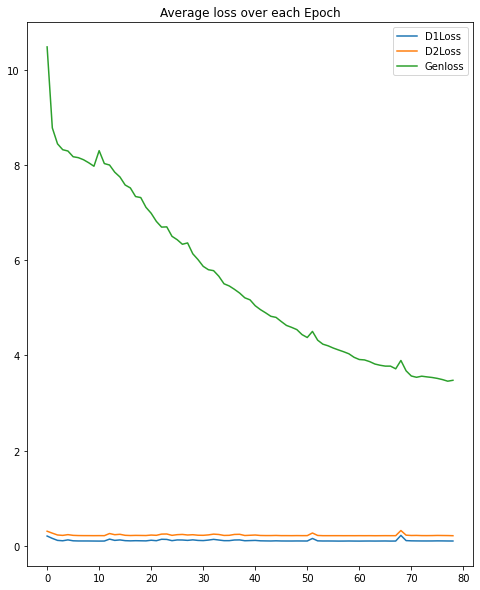

In [ ]:
#average losses over the epochs
plt.figure(figsize=(10,10))
plt.plot(disLoss1,label='D1Loss' ,scalex=True, scaley=True)
plt.plot(disLoss2,label='D2Loss',scalex=True, scaley=True)
plt.plot(genLoss,label='Genloss' ,scalex=True, scaley=True)
plt.title('Average loss over each Epoch')
plt.legend()
plt.show()